In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from random import uniform
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pyDOE import lhs
%matplotlib inline
import os

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        hidden_channle = 40
        self.net = nn.Sequential(
            nn.Linear(2, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, 1)
        )
    def forward(self,x):
        x=self.net(x)
        return x

In [3]:
def u_function(x, t):
    u = model(torch.hstack((x, t)))
    return u

def f_function(x, t, D):
    u = u_function(x, t)
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    u_tt = torch.autograd.grad(u_t, t, torch.ones_like(u_t), retain_graph=True, create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]
    u_xxx = torch.autograd.grad(u_xx, x, torch.ones_like(u_xx), retain_graph=True, create_graph=True)[0]
    u_tx = torch.autograd.grad(u_t, x, torch.ones_like(u_t), retain_graph=True, create_graph=True)[0]
    u_xxt = torch.autograd.grad(u_xx, t, torch.ones_like(u_xx), retain_graph=True, create_graph=True)[0]
    
    f = u_t - D * u_xx + 5 * (u ** 3 - u)
    f_x = u_tx - D * u_xxx + 5 * (3 * (u ** 2) * u_x - u_x)
    f_t = u_tt - D * u_xxt + 5 * (3 * (u ** 2) * u_t - u_t)
    return f, f_x, f_t
    
def Loss(u, x_u, t_u, x_f, t_f, D):
    u_pre = u_function(x_u, t_u)
    f_pre, f_x, f_t= f_function(x_f, t_f, D)
    # loss
    null =  torch.zeros((x_f.shape[0], 1))
    u_loss = loss_fn(u_pre, u)
    f_loss = loss_fn(f_pre, null)
    
    fx_loss = loss_fn(f_x, null)
    ft_loss = loss_fn(f_t, null)
    
    ls = u_loss + f_loss + 0.0001 * fx_loss + 0.0001 * ft_loss
    ls.backward()
    return ls

In [4]:
# 制造数据点集 边界点X_u_train和内点X_f_train
D = 0.0001
N_u = 100
N_f = 50000

# 边界点X_u_train
x_upper = np.ones((N_u//4, 1), dtype=float)
x_lower = np.ones((N_u//4, 1), dtype=float) * (-1)
t_zero = np.zeros((N_u//2, 1), dtype=float)

t_upper = np.random.rand(N_u//4, 1)
t_lower = np.random.rand(N_u//4, 1)
x_zero = np.random.rand(N_u//2, 1) * 2 -1 # 从0，1映射到-1，1

X_upper = np.hstack((x_upper, t_upper)) # 按列拼接
X_lower = np.hstack((x_lower, t_lower))
X_zero = np.hstack((x_zero, t_zero))

X_u_train = np.vstack((X_upper, X_lower, X_zero)) # 按行拼接
index = np.arange(0, N_u)
np.random.shuffle(index)
X_u_train = X_u_train[index, :] # 打乱训练集

# 内点X_f_train
lb = np.array([-1,0])
ub = np.array([-0.6,1])
X_f_train_down = lb + (ub-lb)*lhs(2,N_f*1//16)
lb = np.array([-0.6,0])
ub = np.array([-0.25,1])
X_f_train_down1 = lb + (ub-lb)*lhs(2,N_f*4//16)
lb = np.array([-0.25,0])
ub = np.array([0.25,1])
X_f_train_mid = lb + (ub-lb)*lhs(2,N_f*6//16)
lb = np.array([0.25,0])
ub = np.array([0.6,1])
X_f_train_up1 = lb + (ub-lb)*lhs(2,N_f*4//16)
lb = np.array([0.6,0])
ub = np.array([1,1])
X_f_train_up = lb + (ub-lb)*lhs(2,N_f*1//16)
X_f_train = np.vstack((X_f_train_mid,X_f_train_down,X_f_train_up,X_f_train_down1,X_f_train_up1))
np.random.shuffle(X_f_train)
X_f_train = np.vstack((X_f_train, X_u_train))


# 边界条件u_train
u_upper =  np.ones((N_u//4, 1), dtype=float) * (-1)
u_lower =  np.ones((N_u//4, 1), dtype=float) * (-1)
u_zero = (x_zero ** 2) * np.cos(np.pi * x_zero)  

u_train = np.vstack((u_upper, u_lower, u_zero))

u_train = u_train[index, :] # 对应X_u_train顺序

[Epoch 1/2000] [loss: 0.6326239109039307]
[Epoch 101/2000] [loss: 0.39194953441619873]
[Epoch 201/2000] [loss: 0.003415751736611128]
[Epoch 301/2000] [loss: 0.0020235867705196142]
[Epoch 401/2000] [loss: 0.0015181106282398105]
[Epoch 501/2000] [loss: 0.001245796913281083]
[Epoch 601/2000] [loss: 0.0010966992704197764]
[Epoch 701/2000] [loss: 0.0010074678575620055]
[Epoch 801/2000] [loss: 0.0009485695627517998]
[Epoch 901/2000] [loss: 0.0009065758786164224]
[Epoch 1001/2000] [loss: 0.0008748580585233867]
[Epoch 1101/2000] [loss: 0.0008499110117554665]
[Epoch 1201/2000] [loss: 0.0008297264575958252]
[Epoch 1301/2000] [loss: 0.0008130591595545411]
[Epoch 1401/2000] [loss: 0.0007990841404534876]
[Epoch 1501/2000] [loss: 0.0007872212445363402]
[Epoch 1601/2000] [loss: 0.0007770503871142864]
[Epoch 1701/2000] [loss: 0.0007682564319111407]
[Epoch 1801/2000] [loss: 0.0007605982245877385]
[Epoch 1901/2000] [loss: 0.0007538883946835995]


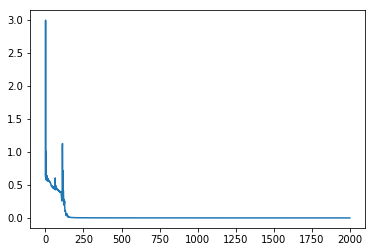

In [5]:
# 模型训练
model=MLP()
loss_fn = nn.MSELoss()  #均方差做损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9) # 动态递减学习率

x_u = torch.tensor(X_u_train[:, 0].reshape(-1, 1), dtype=torch.float32, requires_grad=True)
t_u = torch.tensor(X_u_train[:, 1].reshape(-1, 1), dtype=torch.float32, requires_grad=True)

x_f = torch.tensor(X_f_train[:, 0].reshape(-1, 1), dtype=torch.float32, requires_grad=True)
t_f = torch.tensor(X_f_train[:, 1].reshape(-1, 1), dtype=torch.float32, requires_grad=True)

u = torch.tensor(u_train, dtype=torch.float32)
epochs = 2000
Losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = Loss(u, x_u, t_u, x_f, t_f, D)
    Losses.append(loss.item())
    if epoch % 100 ==0:
        print(f"[Epoch {epoch+1}/{epochs}] [loss: {loss.item()}]")
    optimizer.step()
    scheduler.step()
plt.plot(Losses)
plt.show()

E:\anaconda3\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


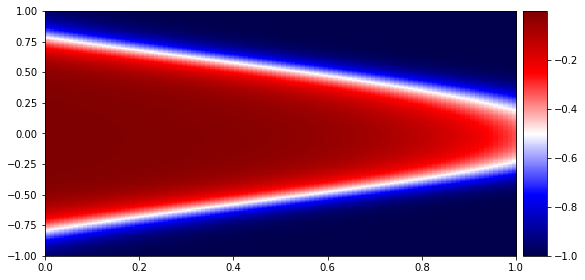

In [6]:
# 可视化
x = torch.linspace(-1, 1, 200, dtype=torch.float32)
t = torch.linspace( 0, 1, 100, dtype=torch.float32)
X, T = torch.meshgrid(x, t)
xcol = X.reshape(-1, 1)
tcol = T.reshape(-1, 1)
u_pre = u_function(xcol, tcol).reshape(x.numel(), t.numel())
xnp = x.numpy()
tnp = t.numpy()
Unp = u_pre.detach().numpy()
# plot:
fig = plt.figure(figsize=(9, 4.5))
ax = fig.add_subplot(111)

h = ax.imshow(Unp,
              interpolation='nearest',
              cmap='seismic', 
              extent=[tnp.min(), tnp.max(), xnp.min(), xnp.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax) # 新建一个坐标轴，右侧
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=10)
plt.show()

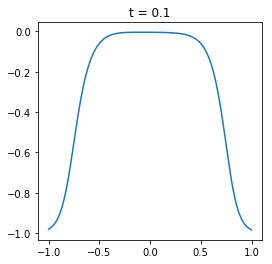

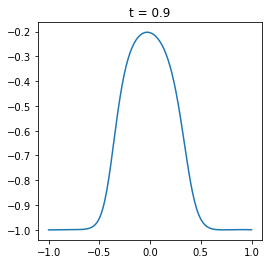

In [7]:
def plot_t(m):
    x = torch.linspace(-1, 1, 200, dtype=torch.float32)
    t = torch.full_like(x, m, dtype=torch.float32)
    xcol = x.reshape(-1, 1)
    tcol = t.reshape(-1, 1)
    u_pre = u_function(xcol, tcol).detach().numpy().reshape(-1, 1)
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.plot(xcol,u_pre)
    title = 't = ' + str(m)
    plt.title(title)
    plt.show()
plot_t(0.1)
plot_t(0.9)

# 软约束

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from random import uniform
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pyDOE import lhs
%matplotlib inline
import os
from scipy.io import loadmat
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        hidden_channle = 40
        self.net = nn.Sequential(
            nn.Linear(2, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, 1)
        )
    def forward(self,x):
        x=self.net(x)
        return x

loadding model!
[Epoch 1/10] [loss: 0.014637293294072151]
model saved at [Epoch 1/10]
[Epoch 10/10] [loss: 0.026990685611963272]


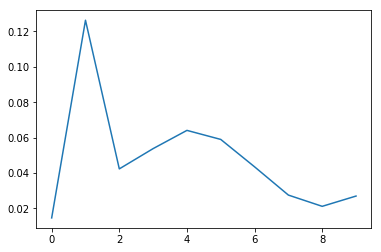

In [2]:
def uu_function(x, t):
    u = model(torch.hstack((x, t)))
    U = t * (1 + x) * (1 - x) * u + torch.square(x) * torch.cos(torch.pi * x)
    return U

def uf_function(x, t, D):
    u = uu_function(x, t)
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    u_tt = torch.autograd.grad(u_t, t, torch.ones_like(u_t), retain_graph=True, create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]
    u_xxx = torch.autograd.grad(u_xx, x, torch.ones_like(u_xx), retain_graph=True, create_graph=True)[0]
    u_tx = torch.autograd.grad(u_t, x, torch.ones_like(u_t), retain_graph=True, create_graph=True)[0]
    u_xxt = torch.autograd.grad(u_xx, t, torch.ones_like(u_xx), retain_graph=True, create_graph=True)[0]
    
    f = u_t - D * u_xx + 5 * (u ** 3 - u)
    f_x = u_tx - D * u_xxx + 5 * (3 * (u ** 2) * u_x - u_x)
    f_t = u_tt - D * u_xxt + 5 * (3 * (u ** 2) * u_t - u_t)
    return f, f_x, f_t
    
def ULoss(x_f, t_f, D):
    f_pre, f_x, f_t= uf_function(x_f, t_f, D)
    # loss
    null =  torch.zeros((x_f.shape[0], 1))
    f_loss = loss_fn(f_pre, null)
    
    fx_loss = loss_fn(f_x, null)
    ft_loss = loss_fn(f_t, null)
    
    ls = f_loss  + 0.0001 * fx_loss + 0.0001 * ft_loss
    ls.backward()
    return ls

D = 0.0001
N_f = 5000
lb = np.array([-1,0])
ub = np.array([-0.6,1])
X_f_train_down = lb + (ub-lb)*lhs(2,N_f*1//16)
lb = np.array([-0.6,0])
ub = np.array([-0.25,1])
X_f_train_down1 = lb + (ub-lb)*lhs(2,N_f*4//16)
lb = np.array([-0.25,0])
ub = np.array([0.25,1])
X_f_train_mid = lb + (ub-lb)*lhs(2,N_f*6//16)
lb = np.array([0.25,0])
ub = np.array([0.6,1])
X_f_train_up1 = lb + (ub-lb)*lhs(2,N_f*4//16)
lb = np.array([0.6,0])
ub = np.array([1,1])
X_f_train_up = lb + (ub-lb)*lhs(2,N_f*1//16)
X_f_train = np.vstack((X_f_train_mid,X_f_train_down,X_f_train_up,X_f_train_down1,X_f_train_up1))
np.random.shuffle(X_f_train)

x_f = torch.tensor(X_f_train[:, 0].reshape(-1, 1), dtype=torch.float32, requires_grad=True)
t_f = torch.tensor(X_f_train[:, 1].reshape(-1, 1), dtype=torch.float32, requires_grad=True)
model=MLP()
loss_fn = nn.MSELoss()  #均方差做损失函数
def train(epochs, Losses, loadding = False):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=400, gamma=0.5) # 动态递减学习率
    file_name = 'C:\\Users\\Fan\\JupyterFile\\DeepLearning\\PINNs\\PINNs_Allen_Cahn.pkl'
    if loadding and os.path.exists(file_name) and os.path.isfile(file_name):
        print('loadding model!')
        model.load_state_dict(torch.load(file_name))
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = ULoss(x_f, t_f, D)
        Losses.append(loss.item())
        if epoch % 100 ==0:
            print(f"[Epoch {epoch+1}/{epochs}] [loss: {loss.item()}]")
        optimizer.step()
        scheduler.step()
        if epoch % 1000 == 0:
            torch.save(model.state_dict(), file_name)
            print(f'model saved at [Epoch {epoch+1}/{epochs}]')
    print(f"[Epoch {epoch+1}/{epochs}] [loss: {loss.item()}]")
    torch.save(model.state_dict(), file_name)
    return Losses
Losses = []
Losses = train(10, Losses, True)
plt.plot(Losses)
plt.show()

E:\anaconda3\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


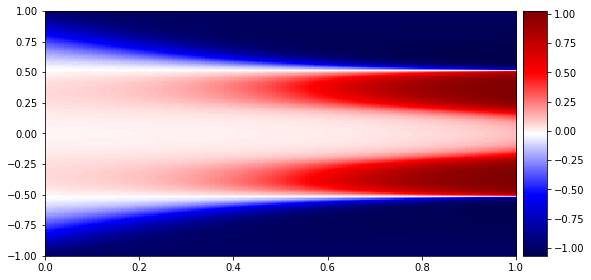

In [3]:
# 可视化
x = torch.linspace(-1, 1, 200, dtype=torch.float32)
t = torch.linspace( 0, 1, 100, dtype=torch.float32)
X, T = torch.meshgrid(x, t)
xcol = X.reshape(-1, 1)
tcol = T.reshape(-1, 1)
u_pre = uu_function(xcol, tcol).reshape(x.numel(), t.numel())
xnp = x.numpy()
tnp = t.numpy()
Unp = u_pre.detach().numpy()
# plot:
fig = plt.figure(figsize=(9, 4.5))
ax = fig.add_subplot(111)

h = ax.imshow(Unp,
              interpolation='nearest',
              cmap='seismic', 
              extent=[tnp.min(), tnp.max(), xnp.min(), xnp.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax) # 新建一个坐标轴，右侧
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=10)
plt.show()

Times: 1 
 Mean f loss: 7.517e-03
loadding model!
[Epoch 1/1000] [loss: 0.0001540728408144787]
model saved at [Epoch 1/1000]
[Epoch 101/1000] [loss: 0.0004043056978844106]
[Epoch 201/1000] [loss: 0.00016613808111287653]
[Epoch 301/1000] [loss: 0.00014731765259057283]
[Epoch 401/1000] [loss: 0.00014210943481884897]
[Epoch 501/1000] [loss: 0.0001406658993801102]
[Epoch 601/1000] [loss: 0.0001394350256305188]
[Epoch 701/1000] [loss: 0.0001383113267365843]
[Epoch 801/1000] [loss: 0.0001372404512949288]
[Epoch 901/1000] [loss: 0.0001367042277706787]
[Epoch 1000/1000] [loss: 0.00013615566422231495]


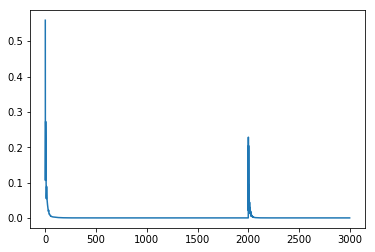

Times: 2 
 Mean f loss: 7.388e-03
loadding model!
[Epoch 1/1000] [loss: 0.0001625762233743444]
model saved at [Epoch 1/1000]
[Epoch 101/1000] [loss: 0.00017999595729634166]
[Epoch 201/1000] [loss: 0.00015604296640958637]
[Epoch 301/1000] [loss: 0.00026199285639449954]
[Epoch 401/1000] [loss: 0.0001502920495113358]
[Epoch 501/1000] [loss: 0.0001487729896325618]
[Epoch 601/1000] [loss: 0.00014730423572473228]
[Epoch 701/1000] [loss: 0.0001458271435694769]
[Epoch 801/1000] [loss: 0.00014432426542043686]
[Epoch 901/1000] [loss: 0.00014354450104292482]
[Epoch 1000/1000] [loss: 0.000142732125823386]


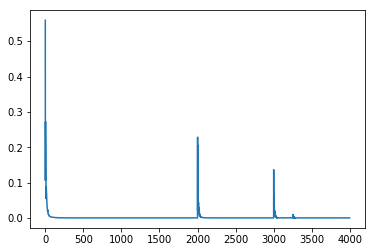

Times: 3 
 Mean f loss: 7.308e-03
loadding model!
[Epoch 1/1000] [loss: 0.0001654184452490881]
model saved at [Epoch 1/1000]
[Epoch 101/1000] [loss: 0.00022617336071562022]
[Epoch 201/1000] [loss: 0.0001672103098826483]
[Epoch 301/1000] [loss: 0.00016063469229266047]
[Epoch 401/1000] [loss: 0.00015836487000342458]
[Epoch 501/1000] [loss: 0.00015737117792014033]
[Epoch 601/1000] [loss: 0.00015632726717740297]
[Epoch 701/1000] [loss: 0.00015522709873039275]
[Epoch 801/1000] [loss: 0.00015406895545311272]
[Epoch 901/1000] [loss: 0.0001534551556687802]
[Epoch 1000/1000] [loss: 0.00015280798834282905]


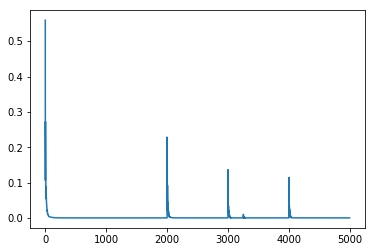

Times: 4 
 Mean f loss: 6.967e-03
loadding model!
[Epoch 1/1000] [loss: 0.00017079184181056917]
model saved at [Epoch 1/1000]
[Epoch 101/1000] [loss: 0.00018829150940291584]
[Epoch 201/1000] [loss: 0.0001626682496862486]
[Epoch 301/1000] [loss: 0.00015977655129972845]
[Epoch 401/1000] [loss: 0.00015775536303408444]
[Epoch 501/1000] [loss: 0.00015668121341150254]
[Epoch 601/1000] [loss: 0.0001555090566398576]
[Epoch 701/1000] [loss: 0.00015424653247464448]
[Epoch 801/1000] [loss: 0.00015289749717339873]
[Epoch 901/1000] [loss: 0.00015217660984490067]
[Epoch 1000/1000] [loss: 0.00015141272160690278]


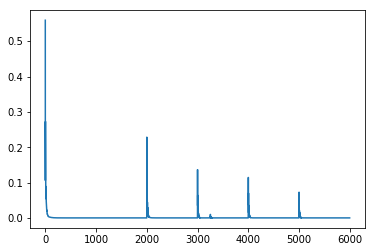

Times: 5 
 Mean f loss: 6.647e-03
loadding model!
[Epoch 1/1000] [loss: 0.0001662901195231825]
model saved at [Epoch 1/1000]
[Epoch 101/1000] [loss: 0.0002974494418594986]
[Epoch 201/1000] [loss: 0.0001751424715621397]
[Epoch 301/1000] [loss: 0.0001638275571167469]
[Epoch 401/1000] [loss: 0.00016075948951765895]
[Epoch 501/1000] [loss: 0.00015977132716216147]
[Epoch 601/1000] [loss: 0.00015882740262895823]
[Epoch 701/1000] [loss: 0.00015788429300300777]
[Epoch 801/1000] [loss: 0.00015692124725319445]
[Epoch 901/1000] [loss: 0.00015641858044546098]
[Epoch 1000/1000] [loss: 0.00015589153917971998]


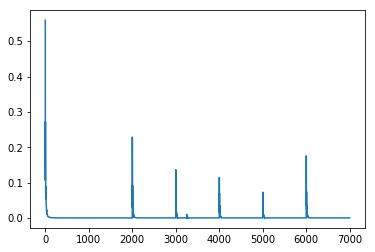

Times: 6 
 Mean f loss: 6.635e-03
loadding model!
[Epoch 1/1000] [loss: 0.00017224843031726778]
model saved at [Epoch 1/1000]
[Epoch 101/1000] [loss: 0.0005143304588273168]
[Epoch 201/1000] [loss: 0.00020059051166754216]
[Epoch 301/1000] [loss: 0.00017595771350897849]
[Epoch 401/1000] [loss: 0.00017084127466659993]
[Epoch 501/1000] [loss: 0.00016955345927271992]
[Epoch 601/1000] [loss: 0.0001684219460003078]
[Epoch 701/1000] [loss: 0.000167341175256297]
[Epoch 801/1000] [loss: 0.00016626704018563032]
[Epoch 901/1000] [loss: 0.0001657137181609869]
[Epoch 1000/1000] [loss: 0.00016513720038346946]


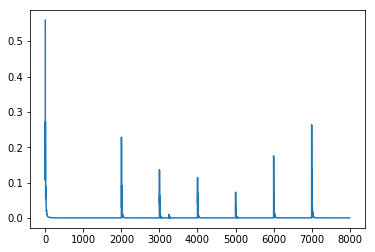

Times: 7 
 Mean f loss: 6.562e-03
loadding model!
[Epoch 1/1000] [loss: 0.00017909755115397274]
model saved at [Epoch 1/1000]
[Epoch 101/1000] [loss: 0.0001935771433636546]
[Epoch 201/1000] [loss: 0.0001739851722959429]
[Epoch 301/1000] [loss: 0.00017066477448679507]
[Epoch 401/1000] [loss: 0.0001712395896902308]
[Epoch 501/1000] [loss: 0.0001685089519014582]
[Epoch 601/1000] [loss: 0.00016689993208274245]
[Epoch 701/1000] [loss: 0.00016533760935999453]
[Epoch 801/1000] [loss: 0.00016371154924854636]
[Epoch 901/1000] [loss: 0.00016284940647892654]
[Epoch 1000/1000] [loss: 0.0001619381655473262]


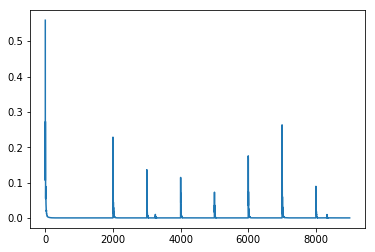

Times: 8 
 Mean f loss: 6.331e-03
loadding model!
[Epoch 1/1000] [loss: 0.00017507956363260746]
model saved at [Epoch 1/1000]
[Epoch 101/1000] [loss: 0.0003794704098254442]
[Epoch 201/1000] [loss: 0.00019582668028306216]
[Epoch 301/1000] [loss: 0.00017784954980015755]
[Epoch 401/1000] [loss: 0.00017353901057504117]
[Epoch 501/1000] [loss: 0.0001723622262943536]
[Epoch 601/1000] [loss: 0.00017131053027696908]
[Epoch 701/1000] [loss: 0.00017028853471856564]
[Epoch 801/1000] [loss: 0.00016925079398788512]
[Epoch 901/1000] [loss: 0.0001687075855443254]
[Epoch 1000/1000] [loss: 0.00016813710681162775]


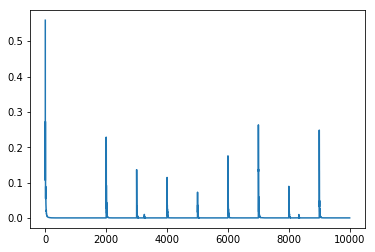

Times: 9 
 Mean f loss: 6.212e-03
loadding model!
[Epoch 1/1000] [loss: 0.00017962428682949394]
model saved at [Epoch 1/1000]
[Epoch 101/1000] [loss: 0.00023666412744205445]
[Epoch 201/1000] [loss: 0.0001855715672718361]
[Epoch 301/1000] [loss: 0.00017829393618740141]
[Epoch 401/1000] [loss: 0.0001751812524162233]
[Epoch 501/1000] [loss: 0.00017381850921083242]
[Epoch 601/1000] [loss: 0.00017240513989236206]
[Epoch 701/1000] [loss: 0.00017092679627239704]
[Epoch 801/1000] [loss: 0.00016937404870986938]
[Epoch 901/1000] [loss: 0.00016855081776157022]
[Epoch 1000/1000] [loss: 0.00016768024943303317]


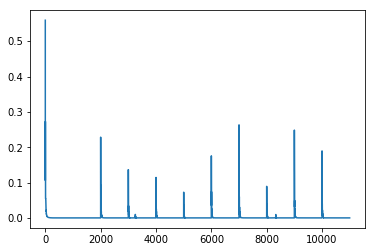

Times: 10 
 Mean f loss: 6.151e-03
loadding model!
[Epoch 1/1000] [loss: 0.00017730328545439988]
model saved at [Epoch 1/1000]
[Epoch 101/1000] [loss: 0.0005847866414114833]
[Epoch 201/1000] [loss: 0.00021349175949580967]
[Epoch 301/1000] [loss: 0.00018209937843494117]
[Epoch 401/1000] [loss: 0.0001760783779900521]
[Epoch 501/1000] [loss: 0.00017456022033002228]
[Epoch 601/1000] [loss: 0.000173195221577771]
[Epoch 701/1000] [loss: 0.00017185726028401405]
[Epoch 801/1000] [loss: 0.00017049521557055414]
[Epoch 901/1000] [loss: 0.0001697821426205337]
[Epoch 1000/1000] [loss: 0.00016903341747820377]


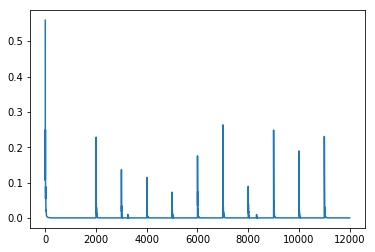

In [4]:
# gPINN + RAR
for i in range(10):
    N_f_rar = 50000
    lb = np.array([-1,0])
    ub = np.array([ 1,1])
    X_f_rar = lb + (ub-lb)*lhs(2,N_f_rar)
    X = torch.tensor(X_f_rar[:, 0].reshape(-1, 1), dtype=torch.float32, requires_grad=True)
    T = torch.tensor(X_f_rar[:, 1].reshape(-1, 1), dtype=torch.float32, requires_grad=True)
    
    f_pre, _, _= uf_function(X, T, D)
    err_eq = torch.abs(f_pre)
    err = torch.mean(err_eq)
    print('Times:',i+1,'\n',"Mean f loss: %.3e" % (err.item()))
    
    x_ids = torch.topk(err_eq, 100, dim=0)[1].numpy()
    for elem in x_ids:
        X_f_train = np.vstack((X_f_rar[elem],X_f_train))
    x_f = torch.tensor(X_f_train[:, 0].reshape(-1, 1), dtype=torch.float32, requires_grad=True)
    t_f = torch.tensor(X_f_train[:, 1].reshape(-1, 1), dtype=torch.float32, requires_grad=True)
    Losses = train(1000, Losses)
    plt.plot(Losses)
    plt.show()

In [4]:
def gen_testdata():
    data = loadmat("C:\\Users\\Fan\\JupyterFile\\DeepLearning\\PINNs\\gpinn-main\\src\\usol_D_0.001_k_5.mat")
    t = data["t"]
    x = data["x"]
    u = data["u"]

    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = u.flatten()[:, None]
    return X, y
XX, yy =gen_testdata()

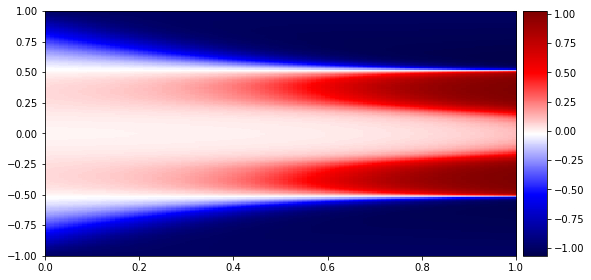

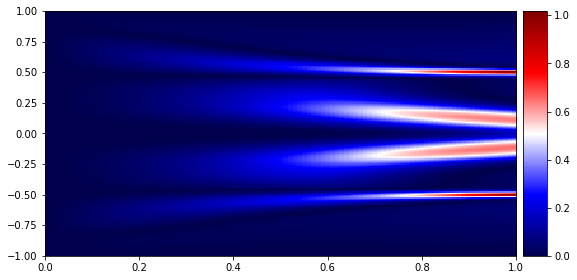

Total Error:0.09032715706403396


In [5]:
# 可视化
#x = torch.linspace(-1, 1, 200, dtype=torch.float32)
#t = torch.linspace( 0, 1, 100, dtype=torch.float32)
#X, T = torch.meshgrid(x, t)
X = torch.tensor(XX[:,0].reshape(-1, 1), dtype=torch.float32, requires_grad=True)
T = torch.tensor(XX[:,1].reshape(-1, 1), dtype=torch.float32, requires_grad=True)
xcol = X.reshape(-1, 1)
tcol = T.reshape(-1, 1)
u_pre = uu_function(xcol, tcol).reshape(101,201).T
Uex= yy.reshape(101,201).T
xnp = x.numpy()
tnp = t.numpy()
Unp = u_pre.detach().numpy()
# plot:
fig = plt.figure(figsize=(9, 4.5))
ax = fig.add_subplot(111)

h = ax.imshow(Unp,
              interpolation='nearest',
              cmap='seismic', 
              extent=[tnp.min(), tnp.max(), xnp.min(), xnp.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax) # 新建一个坐标轴，右侧
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=10)
plt.show()

u_error = np.abs(Unp-Uex)
fig = plt.figure(figsize=(9, 4.5))
ax = fig.add_subplot(111)

h = ax.imshow(u_error,
              interpolation='nearest',
              cmap='seismic', 
              extent=[tnp.min(), tnp.max(), xnp.min(), xnp.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax) # 新建一个坐标轴，右侧
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=10)
plt.show()

error = np.mean(np.squeeze(u_error))
print(f'Total Error:{error}')

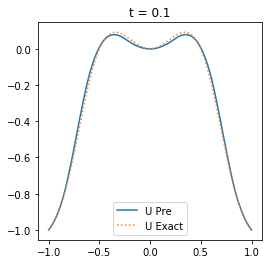

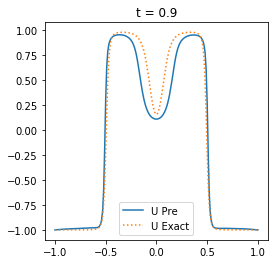

In [16]:
def plot_t(m):
    x = torch.linspace(-1, 1, 201, dtype=torch.float32)
    t = torch.full_like(x, m, dtype=torch.float32)
    xcol = x.reshape(-1, 1)
    tcol = t.reshape(-1, 1)
    u_pre = uu_function(xcol, tcol).detach().numpy().reshape(-1, 1)
    
    index = np.where(XX[:,1]==m)[0]
    u_ex = yy[index]
    
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.plot(xcol,u_pre,label='U Pre')
    ax.plot(xcol,u_ex,linestyle=':',label='U Exact')
    title = 't = ' + str(m)
    plt.legend()
    plt.title(title)
    plt.show()
plot_t(0.1)
plot_t(0.9)